In [1]:
import sys
sys.path.append("../")

# Look at Simulated Data

In [2]:
%load_ext autoreload
%autoreload 2
from scGraphLLM.utils import simulate_data
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [3]:
nclass = 10
ngraphs = 50
nnodes = 10

In [4]:
datasets = simulate_data(num_classes=nclass, graphs_per_class=ngraphs, num_nodes_per_graph=nnodes, 
                         num_edges_per_graph=30, node_embedding_dim=32)

In [5]:
from scGraphLLM.utils import CombinedDataset

In [6]:
combined_dataset = CombinedDataset(datasets)

In [ ]:
fig, axes = plt.subplots(nrows=nclass, ncols=ngraphs, figsize=(20 , 8))
axes = axes.flatten()

data = combined_dataset[0]
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, k=2)

for i in range(10):
    # Convert the i-th graph to a networkx graph
    data = combined_dataset[i]
    G = to_networkx(data, to_undirected=True)
    ax = axes[i]
    cmap = plt.cm.bwr
    edge_weights = [data.edge_attr[j].item() for j in range(data.edge_attr.size(0))]
    edge_colors = [cmap(weight) for weight in edge_weights]
    nx.draw(G, ax=ax, pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=3, edge_color=edge_colors)
    ax.set_title(f'Class {data.y.item()}')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [7]:
from sklearn.decomposition import PCA

In [8]:
import torch

In [9]:
import numpy as np 

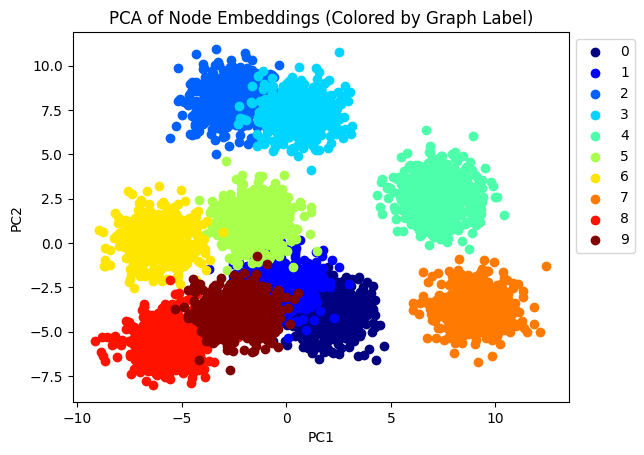

In [10]:
all_embeddings = torch.cat([data.x for data in combined_dataset], dim=0)
all_labels = torch.cat([data.y.repeat(data.x.shape[0]) for data in combined_dataset], dim=0)

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
unique_labels = np.unique(all_labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    plt.scatter(pca_embeddings[all_labels == label, 0], pca_embeddings[all_labels == label, 1], 
                label=label, color=color)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Node Embeddings (Colored by Graph Label)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Train GNN on simulation

In [11]:
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

In [12]:
batch_size = 32
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

In [13]:
for batch in dataloader:
    print("Number of edges:", batch.edge_index.size(1))
    print("Number of edge attributes:", batch.edge_attr.size(0))
    break

Number of edges: 860
Number of edge attributes: 860


In [14]:
len(dataloader)

16

In [15]:
train_size = int(0.7 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

In [16]:
len(train_loader)

10

In [17]:
from torch_geometric.utils import to_dense_adj

In [18]:
len(val_loader)

4

In [72]:
from scGraphLLM.config.model_config import GNNConfig
from scGraphLLM.train import TrainerConfig

In [73]:
gnn_config = GNNConfig()
gnn_config.num_nodes = batch_size * nnodes
gnn_config.input_dim = 32
gnn_config.hidden_dims = (128, 64)
gnn_config.conv_dim = 64
gnn_config.out_dim = nclass

In [74]:
train_config = TrainerConfig()
train_config.lr = 1e-3
train_config.num_epochs = 100
train_config.max_grad = 20.0
train_config.weight_decay = 1e-4
train_config.alpha = 0.001
train_config.verbose = True
train_config.lambda_l1 = 0.01

In [75]:
from scGraphLLM.train import GNN_Trainer

In [76]:
trainer = GNN_Trainer(train_loader, val_loader, gnn_config, train_config)

Number of Attention layers:  3
Number of GNN layers:  4
Number of Batch Normalization layers:  3


In [77]:
model, A, H, Attn, loss_train, loss_val = trainer.train_loop()

[Epoch 0001]  Cross Entropy Loss: 24.53582
[Epoch 0001]  Cross Entropy val: 22.86779
[Epoch 0002]  Cross Entropy Loss: 21.61611
[Epoch 0002]  Cross Entropy val: 20.15949
[Epoch 0003]  Cross Entropy Loss: 19.07677
[Epoch 0003]  Cross Entropy val: 17.82294
[Epoch 0004]  Cross Entropy Loss: 16.90332
[Epoch 0004]  Cross Entropy val: 15.85045
[Epoch 0005]  Cross Entropy Loss: 15.09068
[Epoch 0005]  Cross Entropy val: 14.23514
[Epoch 0006]  Cross Entropy Loss: 13.63580
[Epoch 0006]  Cross Entropy val: 12.94035
[Epoch 0007]  Cross Entropy Loss: 12.38776
[Epoch 0007]  Cross Entropy val: 11.74299
[Epoch 0008]  Cross Entropy Loss: 11.25103
[Epoch 0008]  Cross Entropy val: 10.66880
[Epoch 0009]  Cross Entropy Loss: 10.22195
[Epoch 0009]  Cross Entropy val: 9.69929
[Epoch 0010]  Cross Entropy Loss: 9.30058
[Epoch 0010]  Cross Entropy val: 8.83286
[Epoch 0011]  Cross Entropy Loss: 8.47640
[Epoch 0011]  Cross Entropy val: 8.05898
[Epoch 0012]  Cross Entropy Loss: 7.74503
[Epoch 0012]  Cross Entropy 

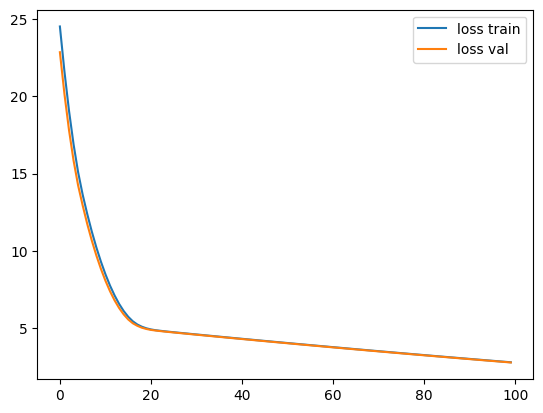

In [78]:
plt.plot(np.clip(loss_train, None, loss_train[0]), label='loss train')
plt.plot(np.clip(loss_val, None, loss_val[0]), label='loss val')
plt.legend()
plt.show()

In [79]:
for data in val_loader:
    data_all = data
    break

In [80]:
data_list = data_all.to_data_list()

In [81]:
graph_id = 2
data_one_graph = data_list[graph_id]
learned_graph = A[0][(10*graph_id) : (10+10*graph_id), (10*graph_id) : (10+10*graph_id)]
learned_graph.shape

torch.Size([10, 10])

In [82]:
from torch_geometric.utils import dense_to_sparse

In [83]:
from matplotlib.colors import LinearSegmentedColormap

In [84]:
data

DataBatch(x=[320, 32], edge_index=[2, 858], edge_attr=[858], y=[32], batch=[320], ptr=[33])

/var/folders/n0/lbm2yq4n3r1gp83zkf5s69j00000gn/T/ipykernel_22770/400542521.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


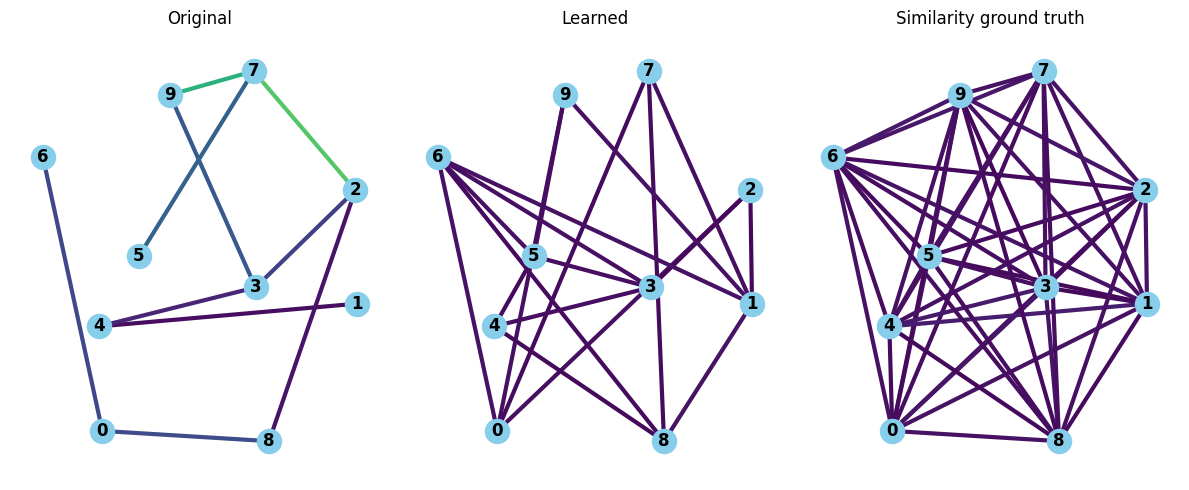

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
axes = axes.flatten()
cmap = plt.cm.get_cmap('viridis')

data = data_one_graph
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, k=2)
edge_weights = [data.edge_attr[j].item() for j in range(data.edge_attr.size(0))]
edge_colors = [cmap(weight) for weight in edge_weights]
nx.draw(G, ax=axes[0], pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=3, edge_color=edge_colors)
axes[0].set_title("Original")

learned, w_learned = dense_to_sparse(learned_graph)
edges = list(zip(learned[0].numpy(), learned[1].numpy()))
G2 = nx.Graph()
G2.add_edges_from(edges)
edge_weights = [w_learned[j].item() for j in range(w_learned.size(0))]
start = np.min(edge_weights)
end = np.max(edge_weights)
shrink_viridis = LinearSegmentedColormap.from_list(
    'shrink_viridis',
    cmap(np.linspace(start, end, 256))
)
cmap = shrink_viridis
edge_colors = [cmap(weight) for weight in edge_weights]
nx.draw(G2, ax=axes[1], pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=3, edge_color=edge_colors)
axes[1].set_title("Learned")


h = H[0][(10*graph_id) : (10+10*graph_id), :]
normed = torch.nn.functional.normalize(h @ h.T, p=2) 
normed = normed * (1-torch.eye(10))
eid, w = dense_to_sparse(normed)
edges = list(zip(eid[0].numpy(), eid[1].numpy()))
G3 = nx.Graph()
G3.add_edges_from(edges)
edge_weights = [w[j].item() for j in range(w.size(0))]
start = np.min(edge_weights)
end = np.max(edge_weights)
shrink_viridis = LinearSegmentedColormap.from_list(
    'shrink_viridis',
    cmap(np.linspace(start, end, 256))
)
cmap = shrink_viridis
edge_colors = [cmap(weight) for weight in edge_weights]
nx.draw(G3, ax=axes[-1], pos=pos, with_labels=True, node_color='skyblue', node_size=300, font_weight='bold', width=3, edge_color=edge_colors)
axes[-1].set_title("Similarity ground truth")



# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [88]:
import seaborn as sns

[Text(0.5, 0, 'away from original'), Text(1.5, 0, 'close to original')]

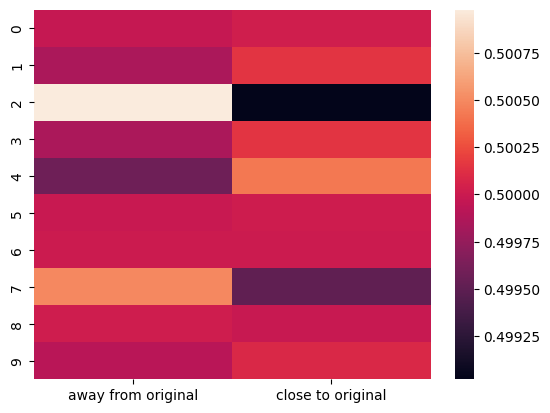

In [96]:
ax = sns.heatmap(Attn[0][0:10, :, :].squeeze().detach().numpy())
ax.set_xticklabels(['away from original', 'close to original'])